In [1]:
%matplotlib notebook

import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import database
from snowballing.operations import reload, work_by_varname, load_work_map_all_years
from snowballing.strategies import Strategy, State
import custom_strategies
from functools import reduce
from matplotlib_venn import venn2, venn2_circles
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

custom_strategies.LIMIT_YEAR = 2015
reload()
# !pip install matplotlib-venn

In [2]:
from snowballing.operations import metakey, metakey_title

def busca(*libraries, seed=None, filter_function=None):
    filter_function = filter_function or (lambda x: x.category in ("snowball",))
    if seed is not None:
        iterable = ((1, work_by_varname(x)) for x in seed)
    else:
        iterable = load_work_map_all_years()
    seedset = set()
    visited = set()
    for _, work in iterable:
        for library in libraries:
            if int(getattr(work, library, 0)):
                visited.add(work)
                if filter_function(work):
                    seedset.add(work)
                break
    return seedset, filter_function, visited

def descreve_delta(strategy, state, name):
    target = state.find(name)
    previous_related = reduce(lambda x, y: x | y, (s.related for s in target.previous[0]), set())
    for work in previous_related:
        backward = set(strategy.ref[work]) & target.delta_visited
        if backward:
            print('backward', work.metakey)
            for ref in backward:
                print('-', ref.metakey, 'related' if ref in target.delta_related else '')
        forward = set(strategy.rev_ref[work]) & target.delta_visited
        if forward:
            print('forward', work.metakey)
            for ref in forward:
                print('-', ref.metakey, 'related' if ref in target.delta_related else '')

def separa_backward_forward(state):
    backward = set()
    forward = set()
    stack = [state]
    visited = {id(state)}
    while stack:
        current = stack.pop()
        if current.previous:
            if current.previous[1] == "backward":
                backward |= current.delta_related
            if current.previous[1] == "forward":
                forward |= current.delta_related
                
            antecessors = current.previous[0]
            for previous in antecessors:
                if id(previous) not in visited:
                    visited.add(id(previous))
                    stack.append(previous)
    return backward, forward

def encontraria(strategy, state):
    backward = set()
    forward = set()
    related = state.related - state.find("s0").related
    for work in state.related:
        backward |= (set(strategy.ref[work]) & related)
        forward |= (set(strategy.rev_ref[work]) & related)
    return backward, forward

#busca("scopus", seed=["wohlin2014a", "briand2000a"], filter_function=lambda x: True)
#busca("scopus", filter_function=lambda x: False)

# Estratégias

## Estratégia 1 - Busca em todas Digital Libraries (DL)

In [3]:
print ("Total de estudos primários usados como Seed Set: ", len ([x for _, x in load_work_map_all_years() if x.category == "snowball"]))


Total de estudos primários usados como Seed Set:  51


In [4]:
print ("Lista de estudos primários usados como Seed Set:")
([x for _, x in load_work_map_all_years() if x.category == "snowball"]) @ metakey_title

Lista de estudos primários usados como Seed Set:


['oConnor2015a - Exploring the use of the cynefin framework to inform software development approach decisions',
 'petersen2015a - An elicitation instrument for operationalising GQM+ Strategies (GQM+ S-EI)',
 'cocozza2014a - Application of GQM+ Strategies in a small software development unit',
 'lepmets2014a - A Cynefin based approach to process model tailoring and goal alignment',
 'trendowicz2014a - Aligning Organizations Through Measurement',
 'unterkalmsteiner2014a - A conceptual framework for SPI evaluation',
 'münch2013a - The effects of gqm+ strategies on organizational alignment',
 'münch2013c - Experiences and insights from applying gqm+ strategies in a systems product development organisation',
 'stallinger2013a - Development and Evaluation of Systems Engineering Strategies: An Assessment-Based Approach',
 'birkhölzer2011a - A framework for systematic evaluation of process improvement priorities',
 'esfahani2011a - Strategically balanced process adoption',
 'kaneko2011a - Appl

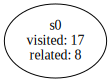

In [5]:
reload()
TOTAL = [x for _, x in load_work_map_all_years() if x.category == "snowball"]
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))

state = strategy.initial
strategy.initial.visited

#strategy.initial.name
state


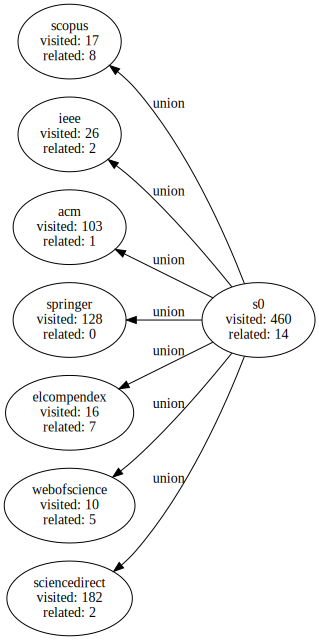

In [6]:
from snowballing.strategies import State

reload()
def busca_completa(libs, filter_function):
    union = None
    for dl in libs:
        strategy = Strategy(*busca(dl, filter_function=filter_function))
        strategy.initial.name = dl
        if union is None:
            union = strategy.initial.derive("union", name="s0")
        else:
            union.visited.update(strategy.initial.visited)
            union.related.update(strategy.initial.related)
            union.previous[0].append(strategy.initial)

    State.last_id = 0
    strategy.initial = union
    return strategy

strategy = busca_completa(["scopus", "ieee", "acm", "springer", "elcompendex", "webofscience", "sciencedirect"], filter_function)
#strategy.initial.find("acm")
strategy.initial

In [7]:
array = []

print ("--- Estratégia 1 (E1) ---")

name = "E1"
EP = len (state.related) / len (state.visited)
print ("Precision: " + "%.2f" %EP)

ER = len (state.related) / len (TOTAL)
print ("Recall: " + "%.2f" %ER)

FS = 2*((EP*ER)/(EP+ER))
print ("F-Measure: " + "%.2f" %FS)

array.append((name, EP, ER, FS))

--- Estratégia 1 (E1) ---
Precision: 0.47
Recall: 0.16
F-Measure: 0.24


## Estratégia 2 - Busca em todas Digital Libraries + Snowballing (Guideline - sfbu)

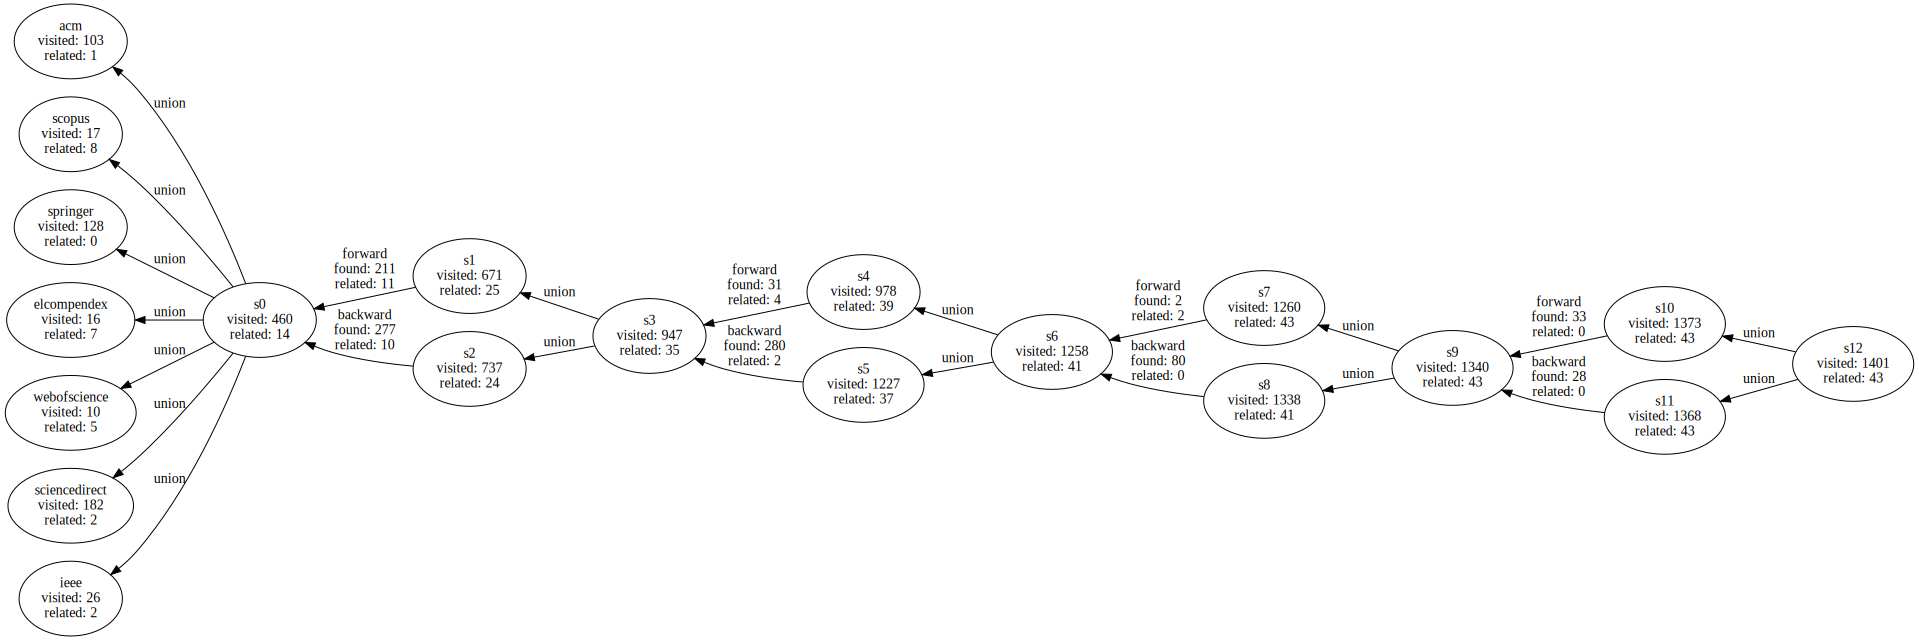

In [8]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = busca_completa(["acm", "scopus", "springer", "elcompendex", "webofscience", "sciencedirect", "ieee"], filter_function)
#Strategy(*busca("acm","scopus", filter_function=filter_function))

state = strategy.sfbu()
#state = strategy.bbff()
#state = strategy.ffbb()
#state = strategy.s2ffbb2u()

state

### Resumo 

#### Resumo da Busca em DL

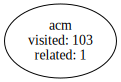

In [9]:
strategy.initial.find("acm")

In [10]:
# Visitados ACM
strategy.initial.find("acm").visited

{Towards a Conceptual Framework and Tool Support for Linking Long-term Product and Business Planning with Agile Software Development,
 Towards Task-based Development of Enterprise Mashups,
 Human-automation Cooperation for Separation Assurance in Future NextGen Environments,
 Balancing Strategic Interests and Technological Requirements for Mobile Services,
 Early Phase Requirements Assessment of a Teletreatment Trial,
 Towards Evolution of Strategic IT Requirements,
 Transformational Government: Basics and Key Issues,
 Experience with Adapting a WS-BPEL Runtime for eScience Workflows,
 Bridging Information Technology and Business&Mdash;Some Modelling Aspects,
 Thinkflickrthink: A Case Study on Strategic Tagging,
 A Model to Incorporate Emotional Sensitivity into Human Computer Interactions,
 eGov Website Evolution Study Within Strategic Planning,
 Calculating and Improving ROI in Software and System Programs,
 ERP: Drilling for Profit in the Oil and Gas Industry,
 Letter from the Edito

In [11]:
# Relacionados ACM - encontrado no seed set
strategy.initial.find("webofscience").related

{ProPAMet: a Metric for process and project alignment,
 An approach to support the strategic alignment of software process improvement programs,
 Software engineering strategies: aligning software process improvement with strategic goals,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 Software process improvement: Supporting the linking of the software and the business strategies}

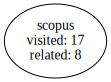

In [12]:
strategy.initial.find("scopus")

In [13]:
print("Visitados Scopus:")
strategy.initial.find("scopus").visited

Visitados Scopus:


{Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 ProPAMet: a Metric for process and project alignment,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 A Low-overhead method for software process appraisal,
 Critical success factors in software process improvement: A systematic review,
 Empirical evaluation of selected best practices in implementation of software process improvement,
 Alignment between the business strategy and the software processes improvement: A roadmap for the implementation [Alinhamento entre estrategia de negocios e melhoria de processos de software: Um roteiro de implementacao],
 A case study applying process and project alignment methodology,
 Software process improvement for the airline industry,
 An approach to support the strategic alignment of software process improvement programs,
 Linking software life cycle activit

In [14]:
print("Relacionados Scopus - encontrado no seed set:")
strategy.initial.find("scopus").related

Relacionados Scopus - encontrado no seed set:


{Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 ProPAMet: a Metric for process and project alignment,
 An approach to support the strategic alignment of software process improvement programs,
 Software engineering strategies: aligning software process improvement with strategic goals,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 A Low-overhead method for software process appraisal,
 Software process improvement: Supporting the linking of the software and the business strategies,
 SPI:I can't get no satisfaction-directing process improvement to meet business needs}

In [15]:
print("Artigo comum a ACM e Scopus:")
strategy.initial.find("acm").visited & strategy.initial.find("scopus").visited

Artigo comum a ACM e Scopus:


set()

#### Resumo do Snowballing

In [16]:
#Total de visitados = visitados no final - visitados no início
print ("Total visitados:")
len(state.visited - state.find("s0").visited)

Total visitados:


941

In [17]:
# Descrição dos Relacionados = relacionados no final - relacionados no início
print ("Total Relacionados: Lista dos que foram encontrados via Snowballing")
state.related - state.find("s0").related

Total Relacionados: Lista dos que foram encontrados via Snowballing


{GQM+ Strategies: A comprehensive methodology for aligning business strategies with software measurement,
 Determining organization-specific process suitability,
 Bridging the gap between business strategy and software development,
 Aggregating viewpoints for strategic software process improvementa method and a case study,
 Blending CMM and Six Sigma to meet business goals,
 An elicitation instrument for operationalising GQM+ Strategies (GQM+ S-EI),
 Development and Evaluation of Systems Engineering Strategies: An Assessment-Based Approach,
 Aligning Organizations Through Measurement,
 Utilizing GQM+ Strategies for an organization-wide earned value analysis,
 GQM+Strategies - Aligning business strategies with software measurement,
 Business objectives as drivers for process improvement: Practices and experiences at Thales Naval the Netherlands (TNNL),
 A framework for systematic evaluation of process improvement priorities,
 Business-oriented software process improvement based on CMM 

In [18]:
print ("Encontrados via somente Snowballing:")
diff_related = state.related - state.find("s2").related
diff_related @ metakey_title

Encontrados via somente Snowballing:


['münch2013a - The effects of gqm+ strategies on organizational alignment',
 'armbrust2010b - Which Processes Are Needed in Five Years? Strategic Process Portfolio Management at the Japan Aerospace Exploration Agency (JAXA)',
 'trendowicz2014a - Aligning Organizations Through Measurement',
 'mcloughlin2010a - The Rosetta Stone Methodology - A benefits-driven approach to software process improvement',
 'basili2007c - GQM+ Strategies: A comprehensive methodology for aligning business strategies with software measurement',
 'unterkalmsteiner2014a - A conceptual framework for SPI evaluation',
 'cocozza2014a - Application of GQM+ Strategies in a small software development unit',
 'trendowicz2011a - Aligning software projects with business objectives',
 'wang2005a - Measuring and improving software process in China',
 'münch2013c - Experiences and insights from applying gqm+ strategies in a systems product development organisation',
 'armbrust2010a - Determining organization-specific process

### Detalhamento por Estado / Aresta

#### Estado S0

#### Visitados

In [19]:
#S0 - Visitados
print("Visitados no Estado 0:")
state.find("s0").visited

Visitados no Estado 0:


{What Are the Knowledge Needs during the Project Lifecycle in an Expert Organisation?,
 Towards Task-based Development of Enterprise Mashups,
 Human-automation Cooperation for Separation Assurance in Future NextGen Environments,
 The Dimensions of Embedded COTS and OSS Software Component Integration,
 GARP --- The Evolution of a Software Acquisition Process Model,
 Software measurement methods: recipes for success?,
 Early Phase Requirements Assessment of a Teletreatment Trial,
 From Knowledge Management Concepts toward Software Engineering Practices,
 Transformational Government: Basics and Key Issues,
 V-BPMI: A variability-oriented framework for web-based business processes modeling and implementation,
 Critical success factors in software process improvement: A systematic review,
 A comparison of issues and advantages in agile and incremental development between state of the art and an industrial case,
 27 - Project planning and control,
 Thinkflickrthink: A Case Study on Strategic

#### Relacionados - Seed Set

In [20]:
#S0 - Relacionados - Encontrados via busca e que existem na lista dos Incluídos da SLR existente - são os seed set!
print("Relacionados no Estado 0: Seed Set")
state.find("s0").related @ metakey_title

Relacionados no Estado 0: Seed Set


['sun2010a - Business-oriented software process improvement based on CMMI using QFD',
 'kaneko2011a - Application of GQM+ Strategies{\textregistered} in the Japanese space industry',
 'martins2008a - ProPAMet: a Metric for process and project alignment',
 'becker2008a - An approach to support the strategic alignment of software process improvement programs',
 'sommerville1999a - Managing process inconsistency using viewpoints',
 'plösch2011a - Software engineering strategies: aligning software process improvement with strategic goals',
 'guzmán2010a - Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations',
 'wilkie2007a - A Low-overhead method for software process appraisal',
 'basili2010a - Linking software development and business strategy through measurement',
 'albuquerque2009a - Software process improvement: Supporting the linking of the software and the business strategies',
 'm

#### Aresta s0 -> s2 (Backward - Iteração 1)

In [21]:
# S2 - Backward (Found) - Visitados na iteração 1
print("Backward - Qtd Referencias dos artigos visitados para chegar ao Estado 2, a partir do Estado 0:")
state.find("s2").delta_visited

Backward - Qtd Referencias dos artigos visitados para chegar ao Estado 2, a partir do Estado 0:


{Information technology - Software process assessment- Part2: A reference model for processes and process capability,
 An empirical investigation of the key factors for success in software process improvement,
 Characterizing the Software Process,
 Organizational alignment and performance: Past, present and future,
 Competitive Strategic Management,
 MPS model and TABA workstation: Implementing software process improvement initiatives in small settings,
 A Semantic approach to monitor business process performance,
 Value creation and capture: A model of the software development process,
 GQM+Strategies: A comprehensive methodology for aligning business strategies with software measurement,
 Process Maturity Profile: CMMI® v1.1, SCAMPI SM v1.1 Class A Appraisal Results,
 Using ViewPoints for Inconsistency Management,
 From process improvement to people improvement: Enabling learning in software development,
 Information technology - Process assessment - Part 3: Guidance on performing an

In [22]:
# S2 - Backward (Related) - Encontrados na iteração 1, via snowballing, que não foi encontrado via busca para o seed set.
print("Relacionados encontrados via Backward, para chegar ao Estado 2, a partir do Estado 0:")
state.find("s2").delta_related @ metakey_title

Relacionados encontrados via Backward, para chegar ao Estado 2, a partir do Estado 0:


['liu2006a - Business-oriented software process improvement based on CMM using QFD',
 'kowalczyk2010a - Aligning software-related strategies in multi-organizational settings',
 'liu2005a - QFD application in software process management and improvement based on CMM',
 'trienekens2009a - Entropy based software processes improvement',
 'martins2007b - ProPAM: SPI based on Process and Project Alignment',
 'debou2000a - Linking software process improvement to business strategies: experiences from industry',
 'basili2007b - GQM+Strategies - Aligning business strategies with software measurement',
 'basili2007a - Bridging the gap between business strategy and software development',
 'becker2008b - Strategic alignment of software process improvement programs using QFD',
 'mccoy1998a - Interfacing three complementary technologies: strategic planning, process modeling, and system dynamics']

#### Aresta s0 -> s1 (Forward - Iteração 1)

In [23]:
# S1 - Forward (Related) - Encontrados na iteração 1
print("Relacionados encontrados via Forward, para chegar ao Estado 1, a partir do Estado 0:")
state.find("s1").delta_related @ metakey_title

Relacionados encontrados via Forward, para chegar ao Estado 1, a partir do Estado 0:


['münch2013a - The effects of gqm+ strategies on organizational alignment',
 'trendowicz2014a - Aligning Organizations Through Measurement',
 'trendowicz2011a - Aligning software projects with business objectives',
 'unterkalmsteiner2014a - A conceptual framework for SPI evaluation',
 'cocozza2014a - Application of GQM+ Strategies in a small software development unit',
 'münch2013c - Experiences and insights from applying gqm+ strategies in a systems product development organisation',
 'mandić2010a - Utilizing GQM+ Strategies for an organization-wide earned value analysis',
 'mandić2010d - SAS: A tool for the GQM+ strategies grid derivation process',
 'karlström2002a - Aggregating viewpoints for strategic software process improvement\x97a method and a case study',
 'petersen2015a - An elicitation instrument for operationalising GQM+ Strategies (GQM+ S-EI)',
 'stallinger2013a - Development and Evaluation of Systems Engineering Strategies: An Assessment-Based Approach']

#### Relacionados - Encontrados Via Backward e Forward

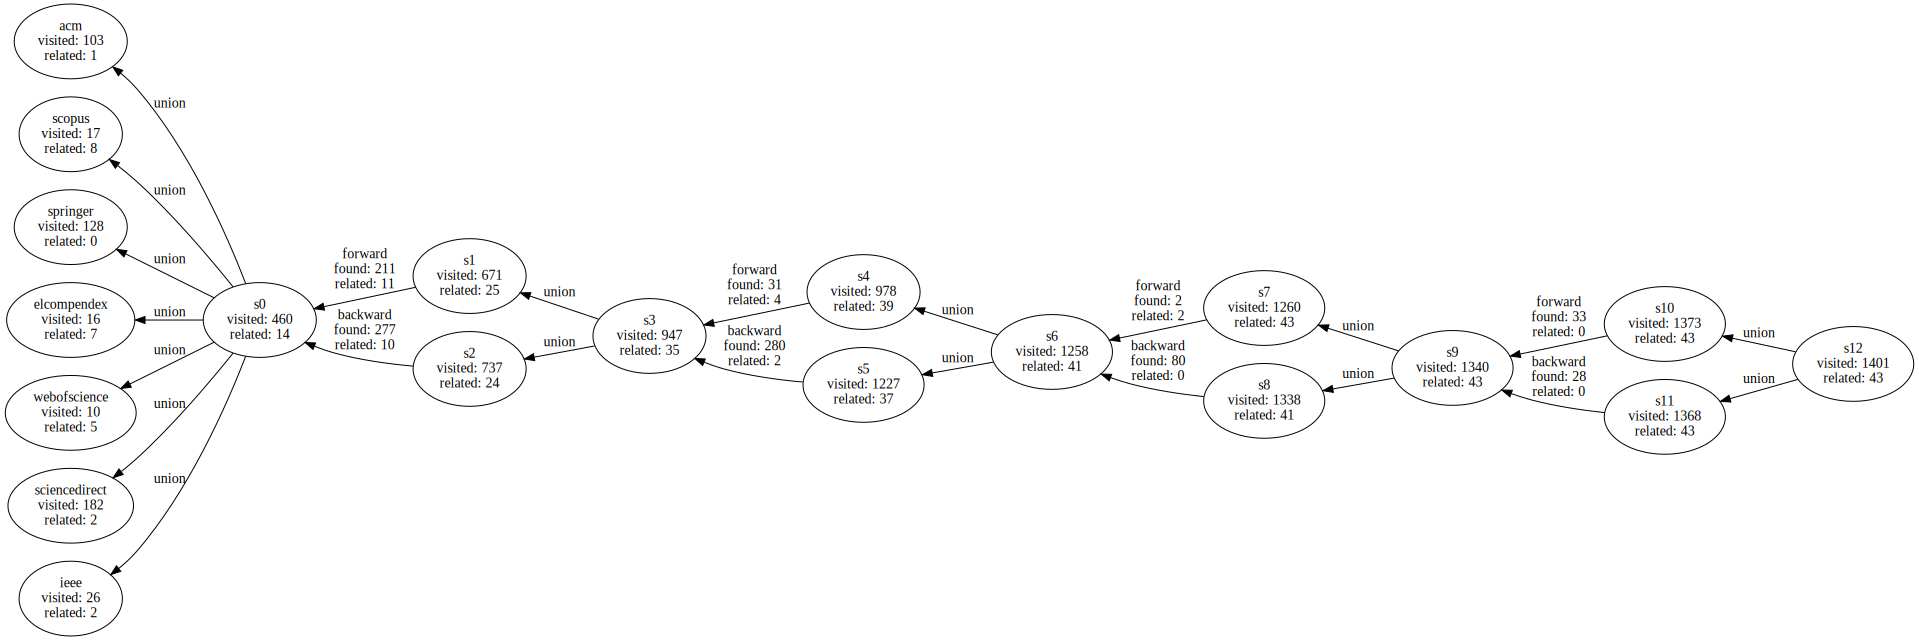

In [24]:
state

In [25]:
# Quantidade de artigo que existe em mais de uma biblioteca, após a união, no Estado S0, Ex, existe 1 artigo em acm e scopus.
state.find("s0").previous[0][1]

(len(strategy.initial.find("acm").visited) + len(strategy.initial.find("scopus").visited) + len(strategy.initial.find("elcompendex").visited) + len(strategy.initial.find("springer").visited) + len(strategy.initial.find("webofscience").visited) + len(strategy.initial.find("sciencedirect").visited)) - len(state.find("s0").visited)

-4

In [26]:
# Artigos encontrados via Backward e Forward - Foi incluído kitchenham 2007a como Snowball para o teste.
print ("Encontrados via Backward e Forward:")
separa_backward_forward(state) @ metakey_title

Encontrados via Backward e Forward:


[['liu2006a - Business-oriented software process improvement based on CMM using QFD',
  'trienekens2009a - Entropy based software processes improvement',
  'basili2007c - GQM+ Strategies: A comprehensive methodology for aligning business strategies with software measurement',
  'debou2000a - Linking software process improvement to business strategies: experiences from industry',
  'basili2007a - Bridging the gap between business strategy and software development',
  'becker2008b - Strategic alignment of software process improvement programs using QFD',
  'murugappan2003a - Blending CMM and Six Sigma to meet business goals',
  'liu2005a - QFD application in software process management and improvement based on CMM',
  'martins2007b - ProPAM: SPI based on Process and Project Alignment',
  'basili2007b - GQM+Strategies - Aligning business strategies with software measurement',
  'kowalczyk2010a - Aligning software-related strategies in multi-organizational settings',
  'mccoy1998a - Interf

In [27]:
def duplicados(strategy, state):
    encontrados = set()
    result = set()
    soma = 0
    related = state.related - state.find("s0").related
    for work in state.related:
        inter = encontrados & (set(strategy.ref[work]) & related)
        if inter:
            soma += len(inter)
            encontrados |= inter
            print(work @ metakey, "backward", inter @ metakey)
        inter = encontrados & (set(strategy.rev_ref[work]) & related)
        if inter:
            soma += len(inter)
            encontrados |= inter
            print(work @ metakey, "forward", inter @ metakey)
    return soma

In [28]:
strategy.forward??

In [29]:
duplicados(strategy, state)

0

<IPython.core.display.Javascript object>


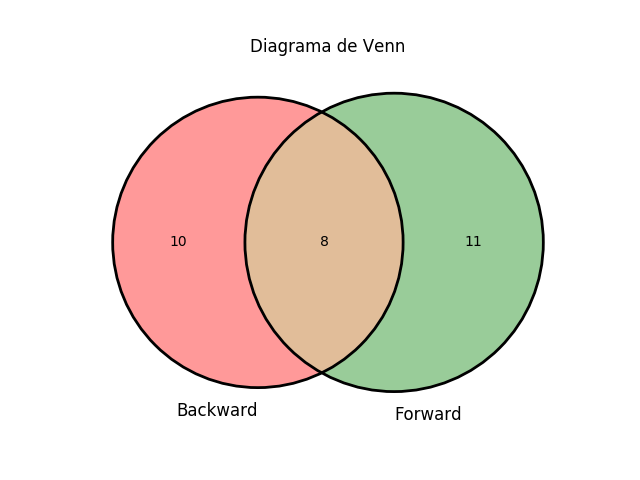

In [30]:
sets = separa_backward_forward(state)
sets = encontraria(strategy, state)
v = venn2(sets, set_labels = ('Backward', 'Forward'))
c = venn2_circles(sets)
plt.title('Diagrama de Venn')
plt.show()

In [33]:
#Backward - Execução de backward em sets[0]
print("Backward", sets[0] @ metakey)
print("Forward", sets[1] @ metakey)

Backward ['münch2013a', 'liu2006a', 'liu2005a', 'martins2007b', 'trendowicz2011a', 'basili2007c', 'trienekens2009a', 'debou2000a', 'münch2013c', 'becker2008b', 'mandić2010a', 'armbrust2010a', 'basili2007b', 'basili2007a', 'kowalczyk2010a', 'mccoy1998a', 'mandić2010d', 'murugappan2003a']
Forward ['armbrust2010a', 'karlström2002a', 'petersen2015a', 'stallinger2013a', 'trendowicz2014a', 'mandić2010a', 'trienekens2004a', 'birkhölzer2011a', 'unterkalmsteiner2014a', 'cocozza2014a', 'münch2013c', 'becker2008b', 'münch2013a', 'armbrust2010b', 'mcloughlin2010a', 'trendowicz2011a', 'wang2005a', 'kowalczyk2010a', 'mandić2010d']


In [34]:
state.find("s0").related @ metakey

['sun2010a',
 'kaneko2011a',
 'martins2008a',
 'becker2008a',
 'sommerville1999a',
 'plösch2011a',
 'guzmán2010a',
 'wilkie2007a',
 'basili2010a',
 'albuquerque2009a',
 'mandić2010b',
 'barreto2010a',
 'trienekens2005a',
 'reiblein1997a']

In [35]:
#x = v.get_patch_by_id('100')

In [36]:
#x.set_linestyle = "black"

In [37]:
#[x.metakey for x in state.find("s0").related]

#### Execução de Backward (Aresta S0 -> S2) em cada artigo relacionado do S0

In [38]:
print("Descreve o S0 -> S2:\n Execução de Backward em cada artigo do related \n")
descreve_delta(strategy, state, "s2")

Descreve o S0 -> S2:
 Execução de Backward em cada artigo do related 

backward sun2010a
- mary2002a 
- card2004a 
- richardson1997a 
- isoiec1998f 
- stelzer1996a 
- liu2006a related
- paulk1993d 
- zaijun2005a 
- choi2005a 
- paulk1993b 
- emam2009a 
- zultner1995a 
- becker2008b related
- serrano2004a 
- liu2006b 
- liu2005a related
- richardson2002a 
- gibson2006a 
- chrissis2003a 
- zultner1992a 
- beijun2008a 
- paulk1994a 
- zultner1992b 
- akao1990c 
- cmmi2006a 
- hierholzer1998a 
backward kaneko2011a
- jaxa2012a 
- isaca2005a 
- isaca2008a 
- kathuria2007a 
- becker1999a 
- ogc2002a 
- basili2009a 
- basili2007b related
- kowalczyk2010a related
- kaplan1992a 
- basili1992a 
backward martins2008a
- paulk1993a 
- krasner1997a 
- emam1999a 
- martins2007b related
- isoiec1998a 
- salo2005a 
- isoiec1998b 
- kuvaja1994a 
- arthur1993a 
- vertage1994a 
- isoiec1998c 
- pfleeger1994a 
- solingen1999a 
- cmm2002a 
backward becker2008a
- dyba2005a 
- humphrey1989b 
- montoni2007a 
- 

#### Execução de Forward em cada artigo relacionado do S1

In [39]:
print("Descreve o S0 -> S1:\n Execução de Forward em cada artigo do related \n")
descreve_delta(strategy, state, "s1")

Descreve o S0 -> S1:
 Execução de Forward em cada artigo do related 

forward kaneko2011a
- teixeira2013a 
- razón2014a 
- asghari2012a 
- heidrich2012b 
- razón2014b 
- trinkenreich2015a 
- kobori2014a 
- petersen2015a related
forward martins2008a
- ollus2011a 
- jansson2015a 
- uoti2011a 
forward sommerville1999a
- lui2008a 
- charrel2007a 
- rayson2000a 
- solaimani2012a 
- katz2004b 
- jesko1999a 
- eljabiri2012a 
- egorova2009a 
- michel2009a 
- taipale2007a 
- karlström2002b 
- ghose2007b 
- morisio2009a 
- karlström2002a related
- karlström2005a 
- kandé2000a 
- berkovich2012a 
- zhiping2011a 
- marcelloni2001a 
- vazquez2000a 
- katz2004a 
- kabbaj2008a 
- alves2002a 
- türetken2007a 
- kim2014a 
- liu2008a 
- easterbrook2001a 
- marcus2005a 
- aysolmaz2011a 
- eljabiri2001a 
- acharya2005a 
- apfelbacher2007a 
- nguyen2003a 
- nguyen2004a 
- yang2007a 
- vázquez2001a 
- jun2007a 
- ghose2007a 
- gans2003a 
- rayson1999b 
- zhang2009a 
- soares2012a 
- bent2006a 
- zhang2010a 


#### Resumo do Precision e Recall

In [40]:
E2P = len (strategy.initial.related) / len (strategy.initial.visited)
#print (len (strategy.initial.related))
#print (len (strategy.initial.visited))
#print (E2P)
print ("Precision na Busca E2: %.2f%%" % E2P)

#print ("Precision no Snowballing - E2:")
#print(len(state.related - state.find("s0").related))
#print(len(state.visited - state.find("s0").visited))

E2PS = len(state.related - state.find("s0").related) / len(state.visited - state.find("s0").visited)

print ("\n""Precision no Snowballing E2: %.2f%%" % E2PS)

print("Precision no Snowballing E2 - Forward - 1 iteração: %.2f%%" % (len (state.find("s1").delta_related) / len (state.find("s1").delta_visited)))

print("Precision no Snowballing E2 - Backward - 1 iteração: %.2f%%" % (len (state.find("s2").delta_related) / len (state.find("s2").delta_visited)))

print("\n""Precision E2 (Busca + Snowballing): %.2f%%" % (len(state.related) / len(state.visited)))

#len (state.find("s1").related)

#len (state.find("s1").delta_related)
#len (state.find("s1").delta_visited)


name = "E2"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)
print ("F-measure " + name)
FS = 2*((EP*ER)/(EP+ER))
print (FS)

array.append((name, EP, ER, FS))


Precision na Busca E2: 0.03%

Precision no Snowballing E2: 0.03%
Precision no Snowballing E2 - Forward - 1 iteração: 0.05%
Precision no Snowballing E2 - Backward - 1 iteração: 0.04%

Precision E2 (Busca + Snowballing): 0.03%
Precision E2
0.030692362598144184
Recall E2
0.8431372549019608
F-measure E2
0.05922865013774105


In [41]:
import statistics as s
s.harmonic_mean([])

StatisticsError: harmonic_mean requires at least one data point

In [ ]:
import statistics as s
from collections import deque
def precision_recall(state, total, stop=""):
    # Precisao 0 quando nao visita nada
    array = [[
        "state", "precision", "recall", "fmeasure", "operation", 
        "related", "visited", "delta_related", "delta_visited",
        "accumulated_precision", "accumulated_recall", "accumulated_fmeasure"
    ]]
    stack = deque([state])
    visited = {id(state)}
    while stack:
        current = stack.pop()
        accumulated_recall = len(current.related) / len(total)
        recall = len(current.delta_related) / len(total)
        try:
            accumulated_precision = len(current.related) / len(current.visited)
            precision = len(current.delta_related) / len(current.delta_visited)
        except ZeroDivisionError:
            precision = float('nan')
        try:
            accumulated_fmeasure = s.harmonic_mean([accumulated_precision, accumulated_recall])
            fmeasure = s.harmonic_mean([precision, recall])
        except ZeroDivisionError:
            fmeasure = float('nan')
            
            
        array.append([
            current.name,
            precision,
            recall,
            fmeasure,
            current.previous[1] if current.previous else "-",
            len(current.related),
            len(current.visited),
            len(current.delta_related),
            len(current.delta_visited),
            accumulated_precision,
            accumulated_recall,
            accumulated_fmeasure,
        ])
        if current.name == stop:
            break
        if current.previous:              
            antecessors = current.previous[0]
            for previous in antecessors:
                if id(previous) not in visited:
                    visited.add(id(previous))
                    stack.appendleft(previous)
    return array

In [ ]:
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
df

In [42]:
df["state"]  + "\n" + df["operation"]

NameError: name 'df' is not defined

<IPython.core.display.Javascript object>


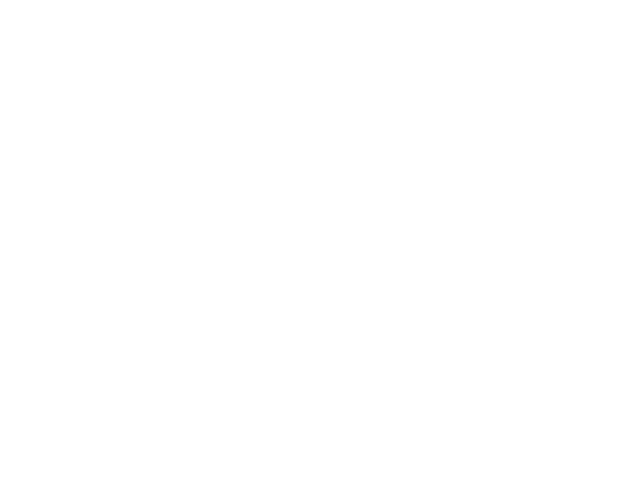

NameError: name 'df' is not defined

In [43]:
fig = plt.figure()
df['precision'].plot(legend=True)
df['recall'].plot(legend=True)
df['fmeasure'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(df["state"] + "\n" + df["operation"])
ax.set_title("By State");
plt.xticks(np.arange(0, len(df), 1.0), rotation='vertical')
plt.xlabel("State\nOperation")
plt.tight_layout()

<IPython.core.display.Javascript object>


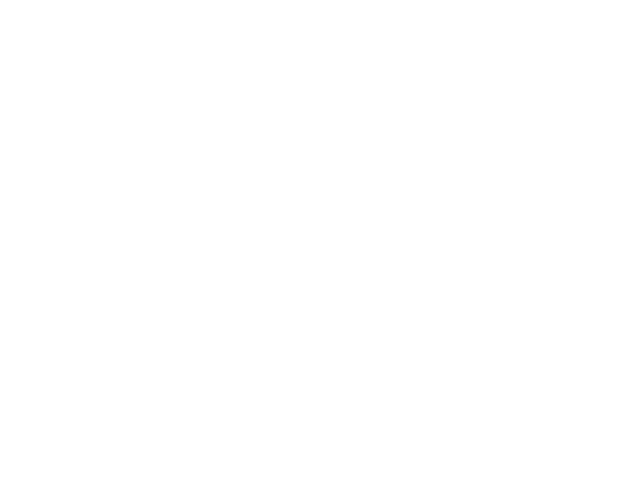

NameError: name 'df' is not defined

In [44]:
fig = plt.figure()
df['accumulated_precision'].plot(legend=True)
df['accumulated_recall'].plot(legend=True)
df['accumulated_fmeasure'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(df["state"] + "\n" + df["operation"])
plt.xticks(np.arange(0, len(df), 1.0), rotation='vertical')
plt.xlabel("State\nOperation")
ax.set_title("Accumulated");
plt.tight_layout()

## Estratégia 3 - Busca Informal (Google Scholar) + Snowballing (Guideline - sfbu)

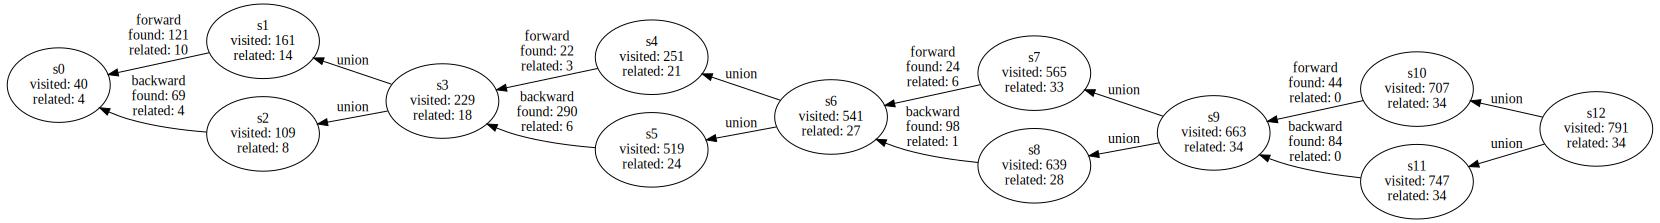

In [45]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("gs", filter_function=filter_function))
state = strategy.sfbu()
state

In [46]:
name = "E3"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

print ("F-measure " + name)
FS = 2*((EP*ER)/(EP+ER))
print (FS)

array.append((name, EP, ER, FS))

Precision E3
0.04298356510745891
Recall E3
0.6666666666666666
F-measure E3
0.08076009501187648



## Estratégia 4 - Busca em Scopus + Snowballing (Guideline - sfbu)

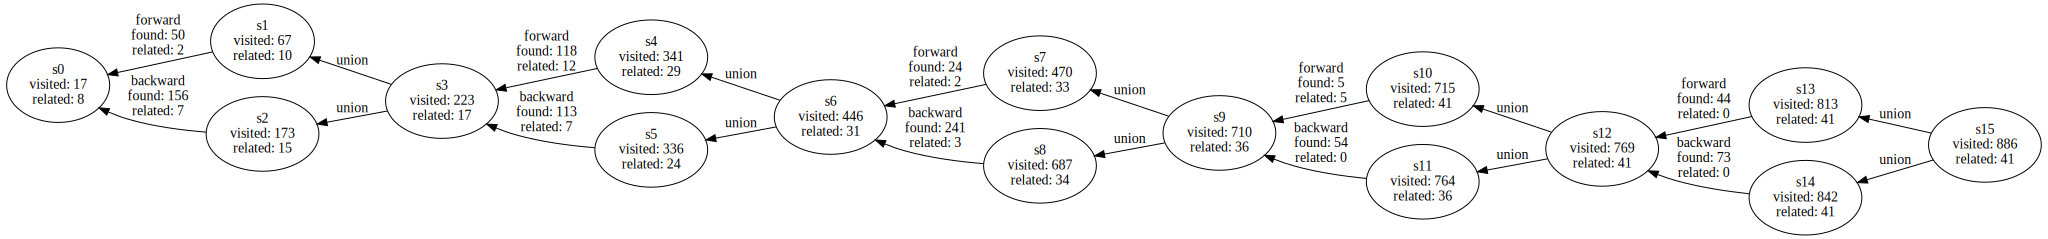

In [47]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))

#from copy import copy
#strategy.initial.visited = copy(strategy.initial.related)
state = strategy.sfbu()
state

In [48]:
descreve_delta(strategy, state, "s2")


backward kaneko2011a
- jaxa2012a 
- isaca2005a 
- isaca2008a 
- kathuria2007a 
- becker1999a 
- ogc2002a 
- basili2009a 
- basili2007b related
- kowalczyk2010a related
- kaplan1992a 
- basili1992a 
backward martins2008a
- paulk1993a 
- krasner1997a 
- emam1999a 
- martins2007b related
- isoiec1998a 
- salo2005a 
- isoiec1998b 
- kuvaja1994a 
- arthur1993a 
- vertage1994a 
- isoiec1998c 
- pfleeger1994a 
- solingen1999a 
- cmm2002a 
backward becker2008a
- dyba2005a 
- humphrey1989b 
- montoni2007a 
- grady1997a 
- pitterman2000a 
- peterson1995a 
- yin2003a 
- biró1999a 
- brodman1995a 
- pulford1996a 
- isoiec2003a 
- akao1990a 
- paulk1993a 
- zaijun2005a 
- yamamura1999a 
- debou1999a 
- zahran1998a 
- liu2005a related
- weber2005a 
- cox1992a 
- chrissis2003a 
- niazi2003a 
- mccoy1998a related
- hierholzer1998a 
backward plösch2011a
- shewhart1931a 
- cmmi2006a 
- dion1993a 
- isoiec2003b 
- isoiec1998d 
- mcfeeley1996a 
- simon2002a 
- venzin2003a 
backward guzmán2010a
- card2003a

In [49]:
texto = """backward becker2008a
- weber2005a 
- hierholzer1998a 
- debou1999a 
- liu2005a 
- yamamura1999a 
- cox1992a 
- grady1997a 
- biró1999a 
- mccoy1998a 
- dyba2005a 
- humphrey1989b 
- paulk1993a 
- chrissis2003a 
- zaijun2005a 
- peterson1995a 
- brodman1995a 
- akao1990a 
- pitterman2000a 
- pulford1996a 
- montoni2007a 
- yin2003a 
- isoiec2003a 
- zahran1998a 
- niazi2003a 
backward martins2008a
- arthur1993a 
- isoiec1998a 
- salo2005a 
- krasner1997a 
- kuvaja1994a 
- cmm2002a 
- isoiec1998c 
- isoiec1998b 
- emam1999a 
- pfleeger1994a 
- solingen1999a 
- paulk1993a 
- vertage1994a 
- martins2007b 
backward reiblein1997a
- kaplan1993a 
- miller1995a 
- trade1992a 
- hinley1997a 
- vlasveld1995a 
- deming1986a 
- group1997a 
- iso1994b 
- itil1989a 
- iso1994a 
- cmm1993a 
- humphrey1989a 
- isoies1997a 
- kaplan1996b 
backward albuquerque2009a
- birk2002a 
- stalhane2004a 
- prahalad1999a 
- softex2009a 
- boehm2000b 
- cmusei2006a 
- nollen2008a 
- salo2005b 
- wright2000a 
- isoiec2004a 
- lawrence2001a 
- reed2000a 
- cater2004a 
- dybå2003b 
- birk1998a 
- bardin1977a 
- hefner2001a 
- thompson2000a 
- kim1995a 
- isoiec2004b 
- alloui2000a 
- caivano2005a 
- mcnair1990a 
- kaplan2000a 
- adams1993a 
- komi2004a 
- martins2007b 
backward kaneko2011a
- kathuria2007a 
- isaca2005a 
- kaplan1992a 
- basili2009a 
- basili2007b 
- becker1999a 
- isaca2008a 
- ogc2002a 
- basili1992a 
- jaxa2012a 
- kowalczyk2010a 
backward guzmán2010a
- ebert2007a 
- mcgarry2002a 
- goethert2004a 
- kaplan2008a 
- chastek2009a 
- tuan2006a 
- basili2009b 
- el2007a 
- sei2006b 
- kojima2008a 
- mishra2008a 
- long2008a 
- watson2007a 
- kanji2007a 
- oliveira2009a 
- porter1979a 
- lamb1984a 
- isoiec2007a 
- asgarkhani2006a 
- harjumaa2008a 
- mcloone2007a 
- mehra2004a 
- kamel2009a 
- card2003a 
- neergaard2007a 
- basili2010a related
- kaplan2005a 
- gopal2005a 
- peng2007a 
- kahraman2007a 
- isoiec2004a 
- fahey2007a 
- kaplan2006a 
- trienekens2009a related
- dyba2005a 
- shull2006a 
- el2001a 
- qi2007a 
- issac2006a 
- isoiec2008a 
- kaplan1997a 
- kuppusamy2008a 
- capell2004a 
- goethert2003a 
backward wilkie2007a
- iso2006a 
- anacleto2004b 
- wilkie2005a 
- mcfeeley1996a 
- anacleto2004a 
- makinen2000a 
- caffery2004a 
- sei2004a 
- wilkie2004a 
- cspt2003a 
- institute2005a 
- chrissis2003a 
- ISOIEC2006a 
- caffery2005a 
- mcfall2003a 
- sei2005a 
- paulk1995a 
- cignoni1999a 
- team2007a 
- rout2001a 
backward plösch2011a
- shewhart1931a 
- isoiec2003b 
- simon2002a 
- venzin2003a 
- cmmi2006a 
- mcfeeley1996a 
- isoiec1998d 
- dion1993a"""

In [50]:
conjuntos = [set(x.split("-")[1:]) for x in texto.split("backward")[1:]]

In [51]:
conjuntos[0] & conjuntos[1]

{' paulk1993a \n'}

In [52]:
name = "E4"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

print ("F-measure " + name)
FS = 2*((EP*ER)/(EP+ER))
print (FS)

array.append((name, EP, ER, FS))

Precision E4
0.046275395033860044
Recall E4
0.803921568627451
F-measure E4
0.08751334044823907


In [53]:
state.find("s0").related

{Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 ProPAMet: a Metric for process and project alignment,
 An approach to support the strategic alignment of software process improvement programs,
 Software engineering strategies: aligning software process improvement with strategic goals,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 A Low-overhead method for software process appraisal,
 Software process improvement: Supporting the linking of the software and the business strategies,
 SPI:I can't get no satisfaction-directing process improvement to meet business needs}

In [54]:
state.find("s2").related

{Entropy based software processes improvement,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 ProPAMet: a Metric for process and project alignment,
 An approach to support the strategic alignment of software process improvement programs,
 Software engineering strategies: aligning software process improvement with strategic goals,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 A Low-overhead method for software process appraisal,
 Linking software development and business strategy through measurement,
 Software process improvement: Supporting the linking of the software and the business strategies,
 QFD application in software process management and improvement based on CMM,
 ProPAM: SPI based on Process and Project Alignment,
 GQM+Strategies - Aligning business strategies with software measurement,
 Aligning software-related strategies in mu

In [55]:
state.find("s0").visited

{Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 ProPAMet: a Metric for process and project alignment,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 A Low-overhead method for software process appraisal,
 Critical success factors in software process improvement: A systematic review,
 Empirical evaluation of selected best practices in implementation of software process improvement,
 Alignment between the business strategy and the software processes improvement: A roadmap for the implementation [Alinhamento entre estrategia de negocios e melhoria de processos de software: Um roteiro de implementacao],
 A case study applying process and project alignment methodology,
 Software process improvement for the airline industry,
 An approach to support the strategic alignment of software process improvement programs,
 Linking software life cycle activit

In [56]:
# Com backward de mendes2004a é possível encontrar 2 (resultado da celula)
state.related & set(strategy.ref[work_by_varname("mendes2004a")])

set()

In [57]:
# Com backward de ... em S2, encontrou 1 (resultado da celula)
state.find("s2").delta_related & set(strategy.ref[work_by_varname("mendes2004a")])

set()

In [58]:
# Com forward de ... em S1, encontrou 1 (resultado da celula)
state.find("s1").delta_related & set(strategy.rev_ref[work_by_varname("mendes2004a")])

set()

In [59]:
len(state.find("s1").delta_visited)

50

In [60]:
#len(state.find("s1").delta_visited & set(strategy.rev_ref[work_by_varname("mendes2004a")]))
# forward
len(set(strategy.rev_ref[work_by_varname("mendes2004a")]))

0

In [61]:
# backward
len(set(strategy.ref[work_by_varname("mendes2004a")]))

0

In [62]:
search_state = strategy.initial
search_state.related

{Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 ProPAMet: a Metric for process and project alignment,
 An approach to support the strategic alignment of software process improvement programs,
 Software engineering strategies: aligning software process improvement with strategic goals,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 A Low-overhead method for software process appraisal,
 Software process improvement: Supporting the linking of the software and the business strategies,
 SPI:I can't get no satisfaction-directing process improvement to meet business needs}

## Estratégia 5 - Busca em Scopus + Snowballing (Short Paper - s2ffbb2u)

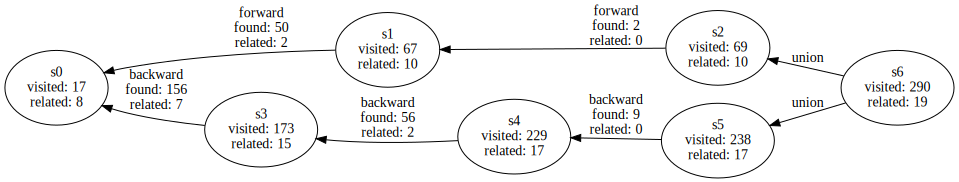

In [63]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.s2bbff2u()
state

In [64]:
name = "E5"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

print ("F-measure " + name)
FS = 2*((EP*ER)/(EP+ER))
print (FS)

array.append((name, EP, ER, FS))

Precision E5
0.06551724137931035
Recall E5
0.37254901960784315
F-measure E5
0.11143695014662758


In [65]:
state.find("s0").related 

{Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 ProPAMet: a Metric for process and project alignment,
 An approach to support the strategic alignment of software process improvement programs,
 Software engineering strategies: aligning software process improvement with strategic goals,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 A Low-overhead method for software process appraisal,
 Software process improvement: Supporting the linking of the software and the business strategies,
 SPI:I can't get no satisfaction-directing process improvement to meet business needs}

In [66]:
state.find("s1").related 

{Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 ProPAMet: a Metric for process and project alignment,
 An approach to support the strategic alignment of software process improvement programs,
 Software engineering strategies: aligning software process improvement with strategic goals,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 A Low-overhead method for software process appraisal,
 Software process improvement: Supporting the linking of the software and the business strategies,
 An elicitation instrument for operationalising GQM+ Strategies (GQM+ S-EI),
 Development and Evaluation of Systems Engineering Strategies: An Assessment-Based Approach,
 SPI:I can't get no satisfaction-directing process improvement to meet business needs}

In [67]:
state.find("s3").related 

{Entropy based software processes improvement,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 ProPAMet: a Metric for process and project alignment,
 An approach to support the strategic alignment of software process improvement programs,
 Software engineering strategies: aligning software process improvement with strategic goals,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 A Low-overhead method for software process appraisal,
 Linking software development and business strategy through measurement,
 Software process improvement: Supporting the linking of the software and the business strategies,
 QFD application in software process management and improvement based on CMM,
 ProPAM: SPI based on Process and Project Alignment,
 GQM+Strategies - Aligning business strategies with software measurement,
 Aligning software-related strategies in mu

In [68]:
sx, sy = state.previous[0]

sx.related & sy.related


{Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 ProPAMet: a Metric for process and project alignment,
 An approach to support the strategic alignment of software process improvement programs,
 Software engineering strategies: aligning software process improvement with strategic goals,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 A Low-overhead method for software process appraisal,
 Software process improvement: Supporting the linking of the software and the business strategies,
 SPI:I can't get no satisfaction-directing process improvement to meet business needs}

In [69]:
sx.name

's2'

In [70]:
sy.name

's5'

In [71]:
# Artigos encontrados via Backward e Forward - Foi incluído kitchenham 2007a como Snowball para o teste.
print ("Encontrados via Backward e Forward:")
separa_backward_forward(state) @ metakey_title

Encontrados via Backward e Forward:


[['trienekens2009a - Entropy based software processes improvement',
  'basili2007c - GQM+ Strategies: A comprehensive methodology for aligning business strategies with software measurement',
  'basili2007a - Bridging the gap between business strategy and software development',
  'basili2010a - Linking software development and business strategy through measurement',
  'liu2005a - QFD application in software process management and improvement based on CMM',
  'martins2007b - ProPAM: SPI based on Process and Project Alignment',
  'basili2007b - GQM+Strategies - Aligning business strategies with software measurement',
  'kowalczyk2010a - Aligning software-related strategies in multi-organizational settings',
  'mccoy1998a - Interfacing three complementary technologies: strategic planning, process modeling, and system dynamics'],
 ['petersen2015a - An elicitation instrument for operationalising GQM+ Strategies (GQM+ S-EI)',
  'stallinger2013a - Development and Evaluation of Systems Engineer

In [72]:
# S1 - Forward (Related) - Encontrados na iteração 1
print("Relacionados encontrados via Forward, para chegar ao Estado 1, a partir do Estado 0:")
state.find("s1").delta_related @ metakey_title

Relacionados encontrados via Forward, para chegar ao Estado 1, a partir do Estado 0:


['petersen2015a - An elicitation instrument for operationalising GQM+ Strategies (GQM+ S-EI)',
 'stallinger2013a - Development and Evaluation of Systems Engineering Strategies: An Assessment-Based Approach']

## Estratégia 6 - Busca em Scopus + Snowballing (JF - bbff)

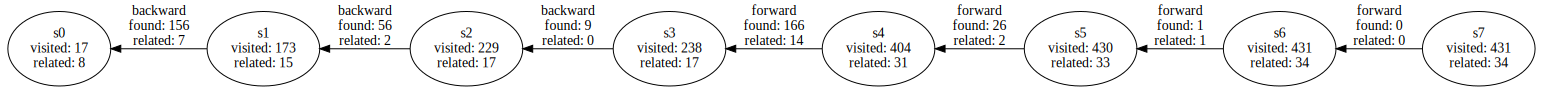

In [73]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.bbff()
state

In [74]:
strategy._repeat??

In [75]:
name = "E6"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

print ("F-measure " + name)
FS = 2*((EP*ER)/(EP+ER))
print (FS)

array.append((name, EP, ER, FS))

Precision E6
0.07888631090487239
Recall E6
0.6666666666666666
F-measure E6
0.14107883817427383


## Estratégia 7 - Busca em Scopus + Snowballing (JF - ffbb)

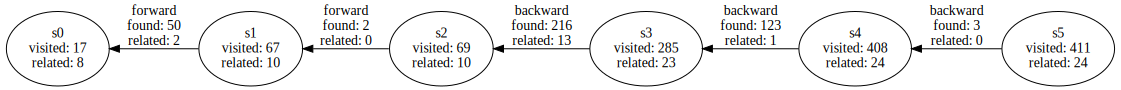

In [76]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.ffbb()
state

In [77]:
name = "E7"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

print ("F-measure " + name)
FS = 2*((EP*ER)/(EP+ER))
print (FS)

array.append((name, EP, ER, FS))

Precision E7
0.058394160583941604
Recall E7
0.47058823529411764
F-measure E7
0.10389610389610389


# Análise das Estratégias

In [78]:
%matplotlib notebook
import pandas as pd

In [79]:
df = pd.DataFrame (array,columns = ['Estratégia','Precision','Recall','F-Measure'])
df.index = df['Estratégia']
df

,Estratégia,Precision,Recall,F-Measure
Estratégia,,,,
E1,E1,0.470588,0.156863,0.235294
E2,E2,0.030692,0.843137,0.059229
E3,E3,0.042984,0.666667,0.080760
E4,E4,0.046275,0.803922,0.087513
E5,E5,0.065517,0.372549,0.111437
E6,E6,0.078886,0.666667,0.141079
E7,E7,0.058394,0.470588,0.103896


<IPython.core.display.Javascript object>


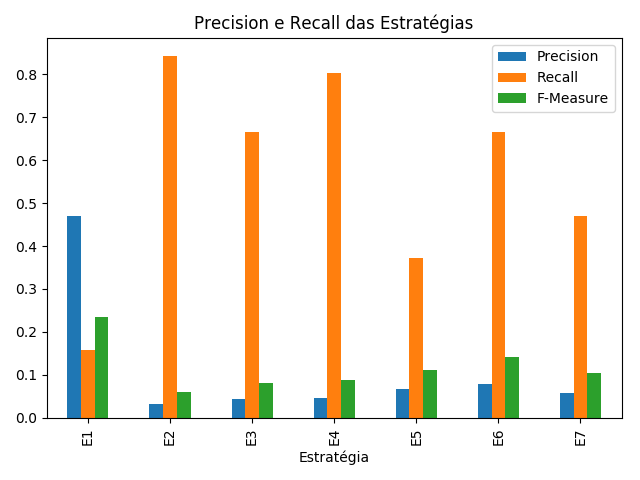

In [80]:
import matplotlib.pyplot as plt
ax = df.plot.bar(title ="Precision e Recall das Estratégias")
plt.tight_layout()


In [82]:
df

,Estratégia,Precision,Recall,F-Measure
Estratégia,,,,
E1,E1,0.470588,0.156863,0.235294
E2,E2,0.030692,0.843137,0.059229
E3,E3,0.042984,0.666667,0.080760
E4,E4,0.046275,0.803922,0.087513
E5,E5,0.065517,0.372549,0.111437
E6,E6,0.078886,0.666667,0.141079
E7,E7,0.058394,0.470588,0.103896


In [83]:
#df.to_csv("estrategias.csv")
df.to_excel("estrategias.xlsx")

# Individual

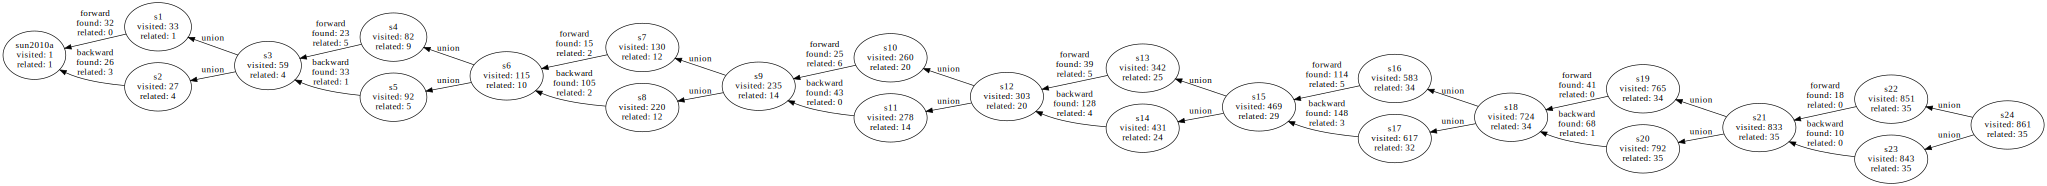

In [115]:
reload()
#NAME = "guzmán2010a"
NAME = "messnarz1999a"
filter_function = lambda x: x.category in ("snowball", "forward", "backward")
seedset = {work_by_varname(NAME)}
strategy = Strategy(seedset, filter_function)
strategy.initial.name = NAME
state = strategy.sfbu()
state

In [109]:
state.find("s1").delta_visited @ metakey_title

['kaneko2011a - Application of GQM+ Strategies{\textregistered} in the Japanese space industry',
 'kowalczyk2013a - A deployment process for strategic measurement systems',
 'heidrich2012b - Tutorial: business IT alignment using the GQM+ Strategies{\textregistered} approach',
 'münch2013c - Experiences and insights from applying gqm+ strategies in a systems product development organisation']

In [ ]:
strategy.bfbf()